In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from matplotlib.patches import Rectangle
# import matplotlib as mpl
# import time
# import torch
# import random

# import sys
# sys.path.append('/home/abenneck/Desktop/yolo_model/docs/scripts')
# from yolo_help import bbox_to_rectangles, imshow, convert_data

# num_ch, tile_dim0, tile_dim1 = 3, 256, 256

import torch
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import random
from matplotlib.patches import Rectangle
import tifffile

import importlib as imp
import sys

sys.path.append('/home/abenneck/Desktop/yolo_tiles/docs/scripts')

import yolo_tiles
imp.reload(yolo_tiles)
from yolo_tiles import img_to_tiles, apply_model_to_tiles, load_test_image, preprocess, remove_bbox_in_overlap

import yolo_help
imp.reload(yolo_help)
from yolo_help import bbox_to_rectangles, imshow, convert_data, Net, get_best_bounding_box_per_cell

import yolo_post_help
imp.reload(yolo_post_help)
from yolo_post_help import remove_low_conf_bboxes, postprocess, bb_to_rec

### Load entire example image

(7584, 9744)


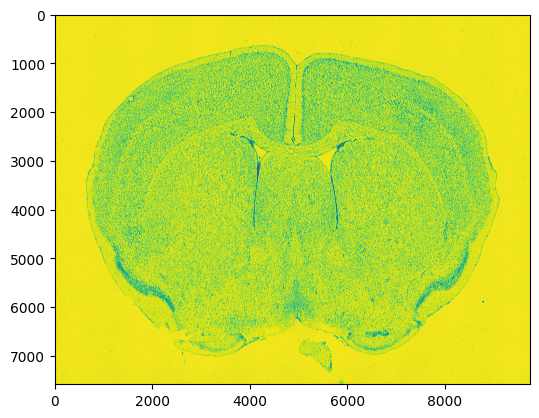

In [2]:
# img_dim0 = 1000
# img_dim1 = 2000
# img = np.random.rand(img_dim0, img_dim1)
img = plt.imread('/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg')
ch_idx = 0
img = img[:,:,ch_idx]
print(np.shape(img))

fig, ax = plt.subplots()
ax.imshow(img)

### Original Tiles

In [1]:
# # Define dimensions of the input image
# # img_dim0 = 1250
# # img_dim1 = 2300
# # img = np.random.rand(img_dim0, img_dim1)

# img = plt.imread('/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg')
# ch_idx = 0
# img = img[:,:,ch_idx]
# img_dim0, img_dim1 = np.shape(img)

# # Define the dimensions of the tiles to be extracted + minimum desired overlap between 2 adjacent tiles
# tile_dim0, tile_dim1 = 256,256
# min_overlap = 16
# outdir = '/home/abenneck/Desktop/yolo_model/tiles_all_ch'

# # If the 'threshold_perc'th percentile of a tile is >= 'threshold_bg', mark it as background
# threshold_bg = 210 # The threshold to determine whether a tile is bg or fg
# threshold_perc = 0.95 # The percentile of all pixels in the tile to check against threshold_bg

# # TODO: If the input image is smaller than the desired tile size, pad the input image with 0s?

# # Compute necessary values along axis 0
# tile_n0 = int(np.floor(img_dim0 / tile_dim0) + 1) # Number of tiles to extract along axis 0
# rem0 = tile_n0 * tile_dim0 - img_dim0 # # Number of REMAINING pixels if all tiles are placed adjacent + not overlapping over the original image
# while rem0 < min_overlap * tile_n0: # If there aren't enough pixels remaining, add another tile, and recompute the remainder. Continue until enough tiles have been added
#     tile_n0 += 1
#     rem0 = tile_n0 * tile_dim0 - img_dim0

# # Compute necessary values along axis 1
# tile_n1 = int(np.floor(img_dim1 / tile_dim1) + 1)
# rem1 = tile_n1 * tile_dim1 - img_dim1
# while rem1 < min_overlap * tile_n1:
#     tile_n1 += 1
#     rem1 = tile_n1 * tile_dim1 - img_dim1

# # Compute size of overlapping regions along each axis
# overlap0 = np.max([min_overlap, int(np.floor(rem0 / (tile_n0 - 1)))])
# overlap1 = np.max([min_overlap, int(np.floor(rem1 / (tile_n1 - 1)))])

# print(f'Dim0: {tile_n0} tiles, with {rem0} extra pixels ({overlap0} overlap)')
# print(f'Dim1: {tile_n1} tiles, with {rem1} extra pixels ({overlap1} overlap)')

# # Determine the upper-left corner of each tile
# all_upper_left_corners = []
# for i in range(tile_n0):
#     coord_dim0 = i*(tile_dim0 - overlap0)
#     if coord_dim0 + tile_dim0 >= img_dim0:
#         coord_dim0 = img_dim0 - tile_dim0
#     for j in range(tile_n1):
#         coord_dim1 = j*(tile_dim1 - overlap1)
#         if coord_dim1 + tile_dim1 >= img_dim1:
#             coord_dim1 = img_dim1 - tile_dim1
#         all_upper_left_corners.append([int(coord_dim0), int(coord_dim1), i, j])

# # Plot the tiles and borders over the input image
# fig, ax = plt.subplots()
# ax.imshow(img)

# for idx, p in enumerate(all_upper_left_corners):
#     if idx % 6 == 0:
#         fc = 'b'
#     else:
#         fc='none'
#     bbox = Rectangle([p[1], p[0]], tile_dim0, tile_dim1, ec='r', fc=fc)
#     ax.add_patch(bbox)

#     idx0 = p[2]
#     idx1 = p[3]
#     p = p[:2]
    
#     sub_img = img[p[0]:p[0]+tile_dim0, p[1]:p[1]+tile_dim1]
#     # print(f'img[{p[0]}:{p[0]+tile_dim0}, {p[1]}:{p[1]+tile_dim1}]')
#     # print(sub_img)
#     if np.percentile(sub_img, threshold_perc) >= threshold_bg:
#         bg = True
#     else:
#         bg = False

#     # p: The (r,c) coord of the corner of the tile closest to the origin
#     np.savez(os.path.join(outdir, f'sub_img_r{idx0}_c{idx1}.npz'), img = sub_img, p = p, bg = bg)
#     # print(f'Saved tile [{idx0},{idx1}]')


# # ax.set_title(f'(over_r, over_c) = ({overlap0},{overlap1})')
# # ax.plot(all_upper_left_corners)

### Extract and save all tiles from an input image

Dim0: 34 tiles with 32 overlap
Dim1: 44 tiles with 32 overlap
Finished extracting + saving all tiles in 3.79s


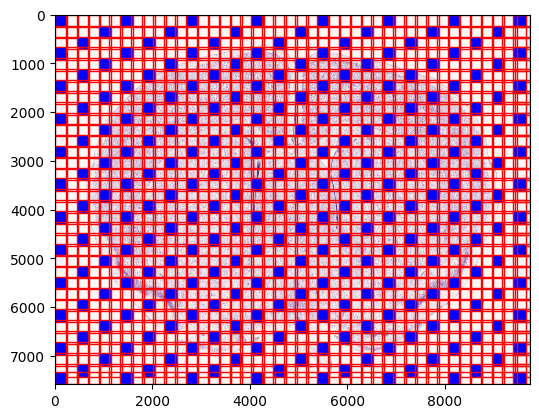

In [24]:
start = time.time()

# Define dimensions of the input image
img = plt.imread('/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg')
img_dim0, img_dim1, num_ch = np.shape(img)

# Define the dimensions of the tiles to be extracted + minimum desired overlap between 2 adjacent tiles
tile_dim0, tile_dim1 = 256,256
min_overlap = 32 # Changed from 16 on 8/26/25
outdir = '/home/abenneck/Desktop/yolo_model/tiles_all_ch'
os.makedirs(outdir, exist_ok=True)

# If the 'threshold_perc'th percentile of a tile is >= 'threshold_bg', mark it as background
threshold_bg = 210 # The threshold to determine whether a tile is bg or fg
threshold_perc = 0.95 # The percentile of all pixels in the tile to check against threshold_bg

# TODO: If the input image is smaller than the desired tile size, pad the input image with 0s?

# Compute necessary values along axis 0
tile_n0 = int(np.floor(img_dim0 / (tile_dim0-min_overlap))) + 1 # Number of tiles to extract along axis 0
tile_n1 = int(np.floor(img_dim1 / (tile_dim1-min_overlap))) + 1

# Compute size of overlapping regions along each axis
overlap0 = min_overlap
overlap1 = min_overlap

print(f'Dim0: {tile_n0} tiles with {min_overlap} overlap')
print(f'Dim1: {tile_n1} tiles with {min_overlap} overlap')

# Determine the upper-left corner of each tile
all_upper_left_corners = []
for i in range(tile_n0):
    coord_dim0 = i*(tile_dim0 - min_overlap)
    if coord_dim0 + tile_dim0 >= img_dim0:
        coord_dim0 = img_dim0 - tile_dim0
    for j in range(tile_n1):
        coord_dim1 = j*(tile_dim1 - min_overlap)
        if coord_dim1 + tile_dim1 >= img_dim1:
            coord_dim1 = img_dim1 - tile_dim1
        all_upper_left_corners.append([int(coord_dim0), int(coord_dim1), i, j])

# Plot the tiles and borders over the input image
fig, ax = plt.subplots()
ax.imshow(img)

for idx, p in enumerate(all_upper_left_corners):
    if idx % 6 == 0:
        fc = 'b'
    else:
        fc='none'
    bbox = Rectangle([p[1], p[0]], tile_dim0, tile_dim1, ec='r', fc=fc)
    ax.add_patch(bbox)

    idx0 = p[2]
    idx1 = p[3]
    p = p[:2]

    # Extract tile to be saved for downstream processing
    sub_img = img[p[0]:p[0]+tile_dim0, p[1]:p[1]+tile_dim1,:]

    # Transpose image, so that it is in the proper format for the YOLO pipeline
    sub_img = np.transpose(sub_img, (2,0,1))

    if np.percentile(sub_img, threshold_perc) >= threshold_bg:
        bg = True
    else:
        bg = False

    # p: The (r,c) coord of the corner of the tile closest to the origin
    if False:
        np.savez(os.path.join(outdir, f'sub_img_r{idx0}_c{idx1}.npz'), img = sub_img, p = p, bg = bg)

print(f'Finished extracting + saving all tiles in {time.time()-start:.2f}s')

## Apply the trained model to each tile

### Load the model

In [2]:
from yolo_help import Net
import torch

outdir_model = os.path.join('/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854')
dtype = torch.float32
# cls_loss = torch.nn.CrossEntropyLoss(reduction='sum')

net = Net()
modelname = 'modelsave.pt'
net.load_state_dict(torch.load(os.path.join(outdir_model,modelname)))

lr = 1e-4
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
optimizername = 'optimizersave.pt'
optimizer.load_state_dict(torch.load(os.path.join(outdir_model,optimizername)))

lossname = 'loss.pt'
Esave = torch.load(os.path.join(outdir_model,lossname))[0]

### Define stitching functions + some bbox filtering

In [3]:
# Check if 'bbox' meets our criteria using 'boundary_cond'
def isValid(bbox, boundary_cond, verbose=False):
    # boundary_cond for exclusion zone and boundary_cond*2 for overlap/buffer zone
    cx, cy, w, h = bbox
    left_bound = cx - w/2
    upper_bound = cy - h/2
    tile_dim0, tile_dim1 = 256, 256

    # if left_bound < 2*boundary_cond[0] or upper_bound < 2*boundary_cond[1]:
    if left_bound < boundary_cond[0] or upper_bound < boundary_cond[1]:
        # Part of bbox lies in the Upper/Left EXCLUSION zone
        if verbose:
            print(f'PART - Removed bbox with bounds ({left_bound:.2f},{upper_bound:.2f})')
        return False
    elif (left_bound >= (tile_dim0 - boundary_cond[0])) or (upper_bound >= (tile_dim1 - boundary_cond[1])):
        # Entire bbox lies in the Lower/Right EXCLUSION zone
        if verbose:
            print(f'ENTIRE - Removed bbox with bounds ({left_bound:.2f},{upper_bound:.2f})')
        return False
    else:
        if verbose:
            print(f'Kept bbox with bounds ({left_bound:.2f},{upper_bound:.2f})')
        return True

# Remove invalid bboxes from 'out' by setting the corresponding conf value in 'out' to -inf
def remove_bbox_in_overlap(out, B, stride, boundary_cond = [16,16]):

    # Get the positions of the grid cells
    x = torch.arange(out.shape[-1])*stride + (stride-1)/2
    y = torch.arange(out.shape[-2])*stride + (stride-1)/2
    YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)

    # Convert bbox0 data to dimensions that are relative to the original input
    outB = out[:,:5]
    x0 = (torch.sigmoid(outB[:,0])-0.5)*stride + YX[1] # between -0.5 and 0.5, scaled
    y0 = (torch.sigmoid(outB[:,1])-0.5)*stride + YX[0]
    w0 = torch.exp(outB[:,2])*stride
    h0 = torch.exp(outB[:,3])*stride
    x0 = x0 - w0/2
    y0 = y0 - h0/2

    # Convert bbox1 data to dimensions that are relative to the original input
    outB = out[:,5:10]    
    x1 = (torch.sigmoid(outB[:,0])-0.5)*stride + YX[1] # between -0.5 and 0.5, scaled
    y1 = (torch.sigmoid(outB[:,1])-0.5)*stride + YX[0]
    w1 = torch.exp(outB[:,2])*stride
    h1 = torch.exp(outB[:,3])*stride
    x1 = x1 - w1/2
    y1 = y1 - h1/2

    # Modify model output by setting conf of invalid bboxes to -inf
    numKeep = 0
    numRemove = 0
    for r in range(np.shape(out)[2]):
        for c in range(np.shape(out)[3]):
            line = out[0,:,r,c]

            # Extract bbox0 info for grid cell (r,c)
            x_ = x0[:,r,c].detach().numpy().item()
            y_ = y0[:,r,c].detach().numpy().item()
            w_ = w0[:,r,c].detach().numpy().item()
            h_ = h0[:,r,c].detach().numpy().item()
            bb0 = np.asarray([x_, y_, w_, h_])

            # print(f'(0,{r},{c}) - {bb0} : ', end='')
            if isValid(bb0, boundary_cond):
                numKeep += 1
            else:
                out[:,4,r,c] = -np.inf
                numRemove += 1

            # Extract bbox1 info for grid cell (r,c)
            x_ = x1[:,r,c].detach().numpy().item()
            y_ = y1[:,r,c].detach().numpy().item()
            w_ = w1[:,r,c].detach().numpy().item()
            h_ = h1[:,r,c].detach().numpy().item()
            bb1 = np.asarray([x_, y_, w_, h_])

            # print(f'(1,{r},{c}) - {bb1} : ', end='')
            if isValid(bb1, boundary_cond):
                numKeep += 1
            else:
                out[:,9,r,c] = -np.inf
                numRemove += 1

    # Extract bbox data from model output
    bboxes,data = convert_data(out,B,stride)
    x = bboxes[...,0]
    y = bboxes[...,1]
    w = bboxes[...,2]
    h = bboxes[...,3]
    c = data[...,-1]
    all_pred_bbox = torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel(),c.ravel()) ).T

    # Objects for downstream data visualiztaion
    bboxes_keep   = all_pred_bbox[np.where(all_pred_bbox[:,-1].detach().numpy() > 0)]
    bboxes_remove = all_pred_bbox[np.where(all_pred_bbox[:,-1].detach().numpy() == 0)]

    return torch.Tensor(out), torch.Tensor(bboxes_keep), torch.Tensor(bboxes_remove)

### Plot the bbox processing for 1 tile

Finished tile 0 in 0.23s


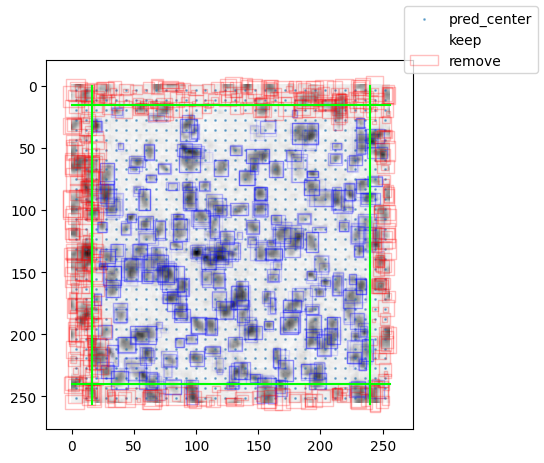

In [11]:
boundary_cond = [16,16]
start = time.time()

src_dir = '/home/abenneck/Desktop/yolo_model/tiles_all_ch'
for i, fname in enumerate(os.listdir(src_dir)):
    data = np.load(os.path.join(src_dir, fname))
    I = data['img']
    p = data['p']
    bg = data['bg']
    
    if bg:
        print(f'Skipping background tile {fname}')
        # I = np.zeros(np.shape(I))
        pass

    # Apply trained model to the image + define some key model outputs
    out = net((torch.tensor(I[None],dtype=dtype)))
    B = net.B
    stride = net.stride
    bboxes,data = convert_data(out,B,stride)
    
    # Convert bbox scale from processed image to original
    fig,ax = plt.subplots()
    x = torch.arange(out.shape[-1])*stride + (stride-1)/2
    y = torch.arange(out.shape[-2])*stride + (stride-1)/2
    YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)
    ax.imshow(I[0],cmap='gray')
    ax.scatter(YX[1].ravel(),YX[0].ravel(),s=1,alpha=0.5)
    # x = bboxes[...,0]
    # y = bboxes[...,1]
    # w = bboxes[...,2]
    # h = bboxes[...,3]
    # c = data[...,-1]

    # Remove bboxes in overlapping region
    # all_pred_bbox = torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T
    out, bbox_keep, bbox_remove = remove_bbox_in_overlap(out, B, stride, boundary_cond = boundary_cond)
    
    # Shift bboxes to the original position
    # bbox_keep[:,0] = bbox_keep[:,0] + p[1]
    # bbox_keep[:,1] = bbox_keep[:,1] + p[0]
    # bbox_remove[:,0] = bbox_remove[:,0] + p[1]
    # bbox_remove[:,1] = bbox_remove[:,1] + p[0]
    
    # Plot all bboxes as rectangles
    conf = bbox_keep[:,-1]
    predicted_rectangles = bbox_to_rectangles(bbox_keep[:,:4].detach().numpy(),fc='none',ec='b',alpha=conf.clone().detach()*0.5)
    ax.add_collection(predicted_rectangles)

    conf = bbox_remove[:,-1]
    removed_rectangles = bbox_to_rectangles(bbox_remove[:,:4].detach().numpy(),fc='none',ec='r',alpha=np.ones([len(conf)])*0.25)
    ax.add_collection(removed_rectangles)

    # Plot exclusion/buffer zone lines (color=lime)
    ax.plot(np.ones(I.shape[1]-1)*boundary_cond[0], np.linspace(0,I.shape[1],I.shape[1]-1), color='lime')
    ax.plot(np.linspace(0,I.shape[2],I.shape[2]-1), np.ones(I.shape[2]-1)*boundary_cond[1], color='lime')
    ax.plot(np.ones(I.shape[1]-1)*(tile_dim0-boundary_cond[0]), np.linspace(0,I.shape[1],I.shape[1]-1), color='lime')
    ax.plot(np.linspace(0,I.shape[2],I.shape[2]-1), np.ones(I.shape[2]-1)*(tile_dim0-boundary_cond[1]), color='lime')

    # Plot overlap zone lines (color=indigo)
    # ax.plot(np.ones(I.shape[1]-1)*boundary_cond[0]*2, np.linspace(0,I.shape[1],I.shape[1]-1), color='indigo')
    # ax.plot(np.linspace(0,I.shape[2],I.shape[2]-1), np.ones(I.shape[2]-1)*boundary_cond[1]*2, color='indigo')
    
    fig.legend(['pred_center','keep','remove'])
    fig.canvas.draw()

    print(f'Finished tile {i} in {time.time()-start:.2f}s')
    start = time.time()
    
    if i == 0:
        break

### Apply the bbox processing to the whole image

Skipping background tile sub_img_r33_c43.npz
Skipping background tile sub_img_r33_c42.npz
Skipping background tile sub_img_r33_c41.npz
Skipping background tile sub_img_r33_c40.npz
Skipping background tile sub_img_r33_c39.npz
Skipping background tile sub_img_r33_c38.npz
Skipping background tile sub_img_r33_c37.npz
Skipping background tile sub_img_r33_c36.npz
Skipping background tile sub_img_r33_c35.npz
Skipping background tile sub_img_r33_c34.npz
Skipping background tile sub_img_r33_c33.npz
Skipping background tile sub_img_r33_c32.npz
Skipping background tile sub_img_r33_c31.npz
Skipping background tile sub_img_r33_c30.npz
Skipping background tile sub_img_r33_c29.npz
Skipping background tile sub_img_r33_c28.npz
Skipping background tile sub_img_r33_c27.npz
Finished tile 18/1496 in 0.24s
Skipping background tile sub_img_r33_c25.npz
Skipping background tile sub_img_r33_c24.npz
Skipping background tile sub_img_r33_c23.npz
Skipping background tile sub_img_r33_c22.npz
Skipping background tile

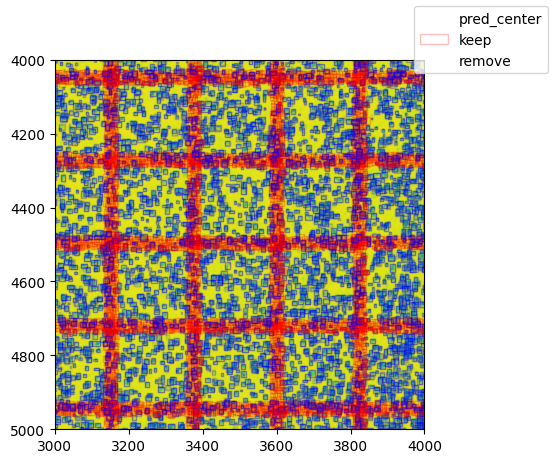

In [32]:
start = time.time()
start_total = time.time()

boundary_cond = [16,16]
img_blank = np.zeros((num_ch, img_dim0, img_dim1))
tile_dim0, tile_dim1 = 256, 256
# tile_n0 and tile_n1 computed during tile preprocessing

ds_factor = 8
bbox_dim = 5
recon_blank = np.zeros((bbox_dim*2+num_ch, int(img_dim0/ds_factor), int(img_dim1/ds_factor)))

ntile_complete = 0
fig,ax = plt.subplots()
src_dir = '/home/abenneck/Desktop/yolo_model/tiles_all_ch'
for r in range(tile_n0)[::-1]:
    for c in range(tile_n1)[::-1]:
        fname = f'sub_img_r{r}_c{c}.npz'
        data = np.load(os.path.join(src_dir, fname))
        I = data['img']
        p = data['p']
        bg = data['bg']
        ntile_complete += 1
        
        if bg:
            print(f'Skipping background tile {fname}')
        else:
            # Plot this tile on the empty canvas
            img_blank[:,p[0]:p[0]+tile_dim0, p[1]:p[1]+tile_dim0] = I
        
            # Apply trained model to the image + define some key model outputs
            out = net((torch.tensor(I[None],dtype=dtype)))
            B = net.B
            stride = net.stride
            out, bbox_keep, bbox_remove = remove_bbox_in_overlap(out, B, stride, boundary_cond = boundary_cond)
            
            # Shift bboxes to the original position
            bbox_keep[:,0] = bbox_keep[:,0] + p[1]
            bbox_keep[:,1] = bbox_keep[:,1] + p[0]
            bbox_remove[:,0] = bbox_remove[:,0] + p[1]
            bbox_remove[:,1] = bbox_remove[:,1] + p[0]
            
            # Plot all bboxes as rectangles
            conf = bbox_keep[:,-1]
            predicted_rectangles = bbox_to_rectangles(bbox_keep[:,:4].detach().numpy(),fc='none',ec='b',alpha=conf.clone().detach()*0.5)
            ax.add_collection(predicted_rectangles)
    
            conf = bbox_remove[:,-1]
            removed_rectangles = bbox_to_rectangles(bbox_remove[:,:4].detach().numpy(),fc='none',ec='r',alpha=np.ones([len(conf)])*0.25)
            ax.add_collection(removed_rectangles)
    
            # Append model output to reconstruction
            recon_blank[:,int(p[0]/ds_factor):int((p[0]+tile_dim0)/ds_factor), int(p[1]/ds_factor):int((p[1]+tile_dim0)/ds_factor)] = out[0].detach().numpy()
                
            print(f'Finished tile {ntile_complete}/{tile_n0*tile_n1} in {time.time()-start:.2f}s')
            start = time.time()

    # if i == 1:
    #     break

fig.legend(['pred_center','keep','remove'])
ax.imshow(img_blank[0])
# ax.set_xlim([3000,4000])
# ax.set_ylim([5000,4000])
# ax.set_xlim([3400,3700])
# ax.set_ylim([4800,4500])
fig.canvas.draw()
if False:
    np.savez(os.path.join(outdir, f'recon.npz'), data = recon_blank)
print(f'Finished entire image in {time.time()-start_total:.2f}s')

### Visualize reconstructed/downsampled image

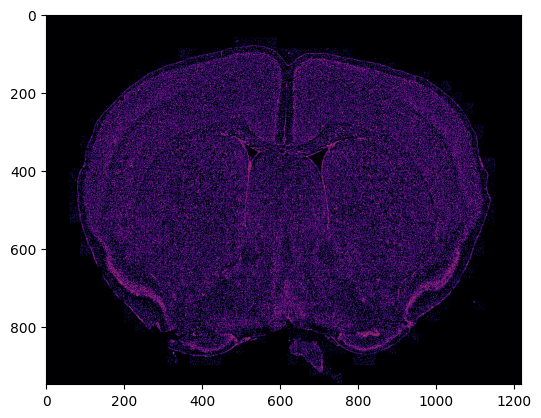

In [374]:
outdir = '/home/abenneck/Desktop/yolo_model/tiles_all_ch'
recon_data = np.load(os.path.join(outdir, f'recon.npz'))
recon_data = recon_data['data']

# np.shape(recon_data)
# recon_data[:,400,600]

fig, ax = plt.subplots()
vis_data = recon_data[9]
vis_transformed = torch.sigmoid(torch.Tensor(vis_data))
vis_transformed[vis_transformed==0.5] = 0
# vis_data = np.reshape(vis_data), (np.shape(vis_data)[1], np.shape(vis_data)[2], np.shape(vis_data)[0]))

ax.imshow(vis_transformed, cmap = 'inferno', vmin=0, vmax=1)

# The Pipeline Functions

In [18]:
# def img_to_tiles(img, outdir='', min_overlap = 32, tile_dim = 256, upper_threshold_bg = np.inf, lower_threshold_bg = -np.inf,verbose = True):
#     start = time.time()
    
#     # Define dimensions of the input image
#     if len(np.shape(img)) == 3:
#         img_dim0, img_dim1, num_ch = np.shape(img)
#         ndim = 3
#     else:
#         raise Exception(f'Input image should be 2 or 3 dimensions, but {len(np.shape(img))} were found')
    
#     # Define the dimensions of the tiles to be extracted + minimum desired overlap between 2 adjacent tiles
#     if outdir != '':
#         os.makedirs(outdir, exist_ok=True)
    
#     # If the 'threshold_perc'th percentile of a tile is >= 'threshold_bg', mark it as background
#     threshold_perc = 0.95 # The percentile of all pixels in the tile to check against threshold_bg
    
#     # Compute number of tiles needed along each axis + necessary padding to preserve stride across tiles
#     tile_n0 = int(img_dim0 / (tile_dim-min_overlap)) + 1 # Number of tiles to extract along axis 0
#     pad_dim0 = ((tile_n0-1)*(tile_dim - min_overlap) + tile_dim)
    
#     tile_n1 = int(img_dim1 / (tile_dim-min_overlap)) + 1 # Number of tiles to extract along axis 1
#     pad_dim1 = ((tile_n1-1)*(tile_dim - min_overlap) + tile_dim)
    
#     # Pad the original input image with zeros
#     left_idx = int((pad_dim0-img_dim0)/2)
#     right_idx = left_idx+img_dim0
#     upper_idx = int((pad_dim1-img_dim1)/2)
#     lower_idx = upper_idx+img_dim1
#     padded_img = np.zeros((pad_dim0, pad_dim1, num_ch), dtype=int)
#     padded_img[left_idx:right_idx, upper_idx:lower_idx] = img
    
#     # Determine the upper-left corner of each tile
#     all_upper_left_corners = []
#     for i in range(tile_n0):
#         coord_dim0 = i*(tile_dim - min_overlap)
#         if coord_dim0 + tile_dim >= pad_dim0:
#             coord_dim0 = pad_dim0 - tile_dim
#         for j in range(tile_n1):
#             coord_dim1 = j*(tile_dim - min_overlap)
#             if coord_dim1 + tile_dim >= pad_dim1:
#                 coord_dim1 = pad_dim1 - tile_dim
#             all_upper_left_corners.append([int(coord_dim0), int(coord_dim1), i, j])

#     # Extract all tiles from the image using the anchor points computed above
#     tiles = []
#     for idx, p in enumerate(all_upper_left_corners):
#         idx0 = p[2]
#         idx1 = p[3]
#         p = p[:2]
    
#         # Extract tile to be saved for downstream processing
#         sub_img = padded_img[p[0]:p[0]+tile_dim, p[1]:p[1]+tile_dim,:]
#         sub_img = np.transpose(sub_img, (2,0,1)) # Transpose image, so that it is in the proper format for the YOLO pipeline
    
#         if np.percentile(sub_img, threshold_perc) >= upper_threshold_bg:
#             bg = True
#         elif np.percentile(sub_img, threshold_perc) <= lower_threshold_bg:
#             bg = True
#         else:
#             bg = False

#         tile = {'img':sub_img, 'p':p, 'bg':bg, 'r_idx':idx0, 'c_idx':idx1}
#         tiles.append(tile)
    
#     if outdir != '':
#         np.savez(os.path.join(outdir, 'tiles.npz'))

#     if verbose:
#         print(f'Finished extracting all tiles in {time.time()-start:.2f}s')

#     # Reverse the order, so now tiles will be parsed in a reverse lexicographic order
#     tiles = tiles[::-1]
    
#     return padded_img, tiles

# def apply_model_to_tiles(tiles, img_dim0, img_dim1, verbose=False):
#     start = time.time()
#     start_total = time.time()

#     # Define dimensions of the input image
#     if len(np.shape(tiles[0]['img'])) == 3:
#         num_ch, tile_dim, _ = np.shape(tiles[0]['img'])
#         tile_ndim = 3
#     else:
#         raise Exception(f'Input image should be 3 dimensions, but {len(np.shape(img))} were found')
    
#     boundary_cond = [16,16]
#     # TODO: when implementing UI using argparse, Boundary_cond = min_overlap / 2
#     ds_factor = 8
#     bbox_dim = 5
#     num_classes = 3
#     B = net.B
#     stride = net.stride
    
#     # img_blank = np.zeros((num_ch, img_dim0, img_dim1))
#     recon_blank = np.ones((bbox_dim*B+num_classes, int(img_dim0/ds_factor), int(img_dim1/ds_factor)))*-1
    
#     ntile_complete = 0
#     for tile in tiles:
#         I = tile['img']
#         p = tile['p']
#         bg = tile['bg']
#         r_idx = tile['r_idx']
#         c_idx = tile['c_idx']
        
#         if bg:
#             print(f'Skipping background tile (r,c):({r_idx},{c_idx})')
#         else:
#             # Plot this tile on the empty canvas
#             # img_blank[:,p[0]:p[0]+tile_dim, p[1]:p[1]+tile_dim] = I
        
#             # Apply trained model to the image + define some key model outputs
#             out = net((torch.tensor(I[None],dtype=dtype)))
#             out, _, _ = remove_bbox_in_overlap(out, B, stride, boundary_cond = boundary_cond)
            
#             # Adjust bboxes if anchor point is not a multiple of ds_factor (09/08/25: Needed to adjust for edge case)
#             if p[0] % ds_factor != 0:
#                 out[0,1,:,:] += (p[0] % ds_factor)
#                 out[0,6,:,:] += (p[0] % ds_factor)
#             if p[1] % ds_factor != 0:
#                 out[0,0,:,:] += (p[1] % ds_factor)
#                 out[0,5,:,:] += (p[1] % ds_factor)
            
#             # Append model output to reconstruction
#             recon_blank[:,int(p[0]/ds_factor):int((p[0]+tile_dim)/ds_factor), int(p[1]/ds_factor):int((p[1]+tile_dim)/ds_factor)] = out[0].detach().numpy()
            
#             print(f'Finished tile {ntile_complete}/{len(tiles)} in {time.time()-start:.2f}s')
#             start = time.time()
    
#         ntile_complete += 1

#     return torch.Tensor(recon_blank)

# def count_bbox(out):
#     n0 = 0
#     for elem in out[4]:
#         n0 += len(np.where(np.isfinite(elem))[0])
#     for elem in out[9]:
#         n0 += len(np.where(np.isfinite(elem))[0])
#     return n0

### Apply model to large input image

In [20]:
img = plt.imread('/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg')
padded_img, tiles = img_to_tiles(img, upper_threshold_bg = 210)
out = apply_model_to_tiles(tiles, padded_img.shape[0], padded_img.shape[1], verbose=True)

### Plot model output on original input image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Finished entire image in 30.24s


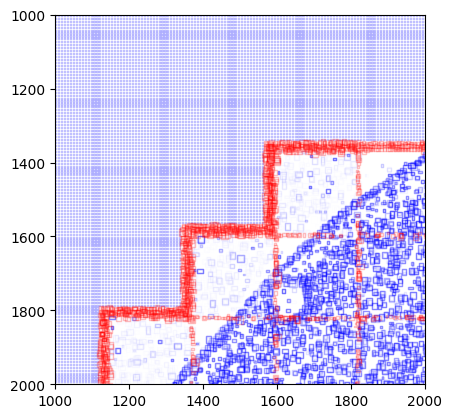

In [53]:
start = time.time()

fig, ax = plt.subplots()
ax.imshow(padded_img)

B = net.B
stride = net.stride

bboxes, data = convert_data(out[None], B, stride)
scores = data[:,-1]

# Plot all bboxes as rectangles
bbox_keep = bboxes[np.where(scores>0)]
s_keep = scores[np.where(scores>0)]
predicted_rectangles = bbox_to_rectangles(bbox_keep[:,:4].detach().numpy(),fc='none',ec='b',alpha=s_keep.clone().detach()*0.5)
ax.add_collection(predicted_rectangles)

bbox_remove = bboxes[np.where(scores<=0)]
s_remove = scores[np.where(scores<=0)]
if len(s_remove) > 0:
    removed_rectangles = bbox_to_rectangles(bbox_remove[:,:4].detach().numpy(),fc='none',ec='r',alpha=np.ones([len(s_remove)])*0.25)
    ax.add_collection(removed_rectangles)

ax.set_xlim([1000,2000])
ax.set_ylim([2000,1000])

print(f'Finished entire image in {time.time()-start:.2f}s')

In [57]:
u_arr, c_arr = np.unique(scores, return_counts = True)

list(zip(u_arr,c_arr))
# list(zip(u_arr,c_arr))[::-1]

[(0.0, 124754),
 (3.1922207e-38, 1),
 (3.320448e-38, 1),
 (3.3204734e-38, 1),
 (3.4978195e-38, 1),
 (1.7545731e-37, 1),
 (2.006784e-37, 1),
 (2.868495e-37, 1),
 (3.7668275e-37, 1),
 (4.139766e-37, 1),
 (5.4850943e-37, 1),
 (5.7880236e-37, 1),
 (8.323475e-37, 1),
 (1.0426126e-36, 1),
 (3.9286597e-36, 1),
 (7.1172495e-36, 1),
 (1.2478874e-35, 1),
 (1.5682017e-35, 1),
 (2.3252677e-35, 1),
 (4.3025455e-35, 1),
 (4.4393603e-35, 1),
 (6.044322e-35, 1),
 (7.688749e-35, 1),
 (7.7262655e-35, 1),
 (9.636055e-35, 1),
 (1.1314529e-34, 1),
 (1.3041537e-34, 1),
 (1.3978083e-34, 1),
 (1.7250491e-34, 1),
 (1.9947662e-34, 1),
 (2.4923e-34, 1),
 (3.6568082e-34, 1),
 (4.2325965e-34, 1),
 (4.598894e-34, 1),
 (5.847175e-34, 1),
 (6.0592156e-34, 1),
 (8.360879e-34, 1),
 (8.993007e-34, 1),
 (1.2798522e-33, 1),
 (1.3183248e-33, 1),
 (1.8756912e-33, 1),
 (1.9309993e-33, 1),
 (1.9368418e-33, 1),
 (2.0277652e-33, 1),
 (2.3359923e-33, 1),
 (2.7401097e-33, 1),
 (2.8600002e-33, 1),
 (4.1921218e-33, 1),
 (4.6998274e

In [58]:
len(bboxes)
scores = data[:,-1]
bb_keep = bboxes[np.where(scores>0)]
bb_remove = bboxes[np.where(scores<=0)]
print(f'Keep: {len(bb_keep)}, Remove: {len(bb_remove)}')

Keep: 2238478, Remove: 124754


## Test Case

Finished extracting all tiles in 0.02s
Finished tile 0/9 in 0.12s
Finished tile 1/9 in 0.14s
Finished tile 2/9 in 0.12s
Finished tile 3/9 in 0.12s
Finished tile 4/9 in 0.14s
Finished tile 5/9 in 0.12s
Finished tile 6/9 in 0.13s
Finished tile 7/9 in 0.12s
Finished tile 8/9 in 0.12s
13610/15488 bbox counted, 900 cells present
Finished entire image in 0.08s


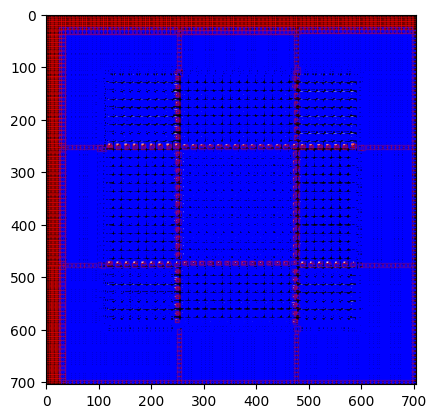

In [19]:
# Create test image
img_dim0, img_dim1 = 500,500
# img_dim0, img_dim1 = 256,256
img = np.zeros((img_dim0, img_dim1, num_ch))
scale = 16
r = 4
Y, X = np.ogrid[:img_dim0, :img_dim1]
total_bbox = 0
for i in range(int(img_dim0/scale)):
    for j in range(int(img_dim1/scale)):
        if i > 0 and j > 0:
            # if (i+j)%2 == 0:
            #     r = 3
            # else:
            #     r = 5
            mask = (X - scale*i)**2 + (Y - scale*j)**2 <= r**2
            img[mask,:]=1
            total_bbox += 1

# Extract 'tiles' from larger input img
padded_img, tiles = img_to_tiles(img, upper_threshold_bg = 210)

# Apply model to tiles + apply bbox edge filtering
out = apply_model_to_tiles(tiles, padded_img.shape[0], padded_img.shape[1])

# Count the number of bboxes output from the model
n_bbox = count_bbox(out)
print(f'{n_bbox}/{out.shape[1]*out.shape[2]*2} bbox counted, {total_bbox} cells present')

start = time.time()
start_total = time.time()

fig, ax = plt.subplots()
ax.imshow(img)
ax.imshow(padded_img)

B = net.B
stride = net.stride

bboxes, data = convert_data(out[None], B, stride)
scores = data[:,-1]
bbox_keep = bboxes[np.where(scores>0)]
s_keep = scores[np.where(scores>0)]
bbox_remove = bboxes[np.where(scores<=0)]
s_remove = scores[np.where(scores<=0)]

# Plot all bboxes as rectangles
conf = s_keep
predicted_rectangles = bbox_to_rectangles(bbox_keep[:,:4].detach().numpy(),fc='none',ec='b')#,alpha=conf.clone().detach()*0.5)
ax.add_collection(predicted_rectangles)

conf = s_remove
if len(conf) > 0:
    removed_rectangles = bbox_to_rectangles(bbox_remove[:,:4].detach().numpy(),fc='none',ec='r',alpha=np.ones([len(conf)])*0.25)
    ax.add_collection(removed_rectangles)
else:
    print('No bboxes removed from overlap')

# ax.set_xlim([1000,2000])
# ax.set_ylim([2000,1000])

print(f'Finished entire image in {time.time()-start_total:.2f}s')

### Additional bbox filtering

Finished Best bbox per cell in 0.03s
Finished low conf in 0.09s


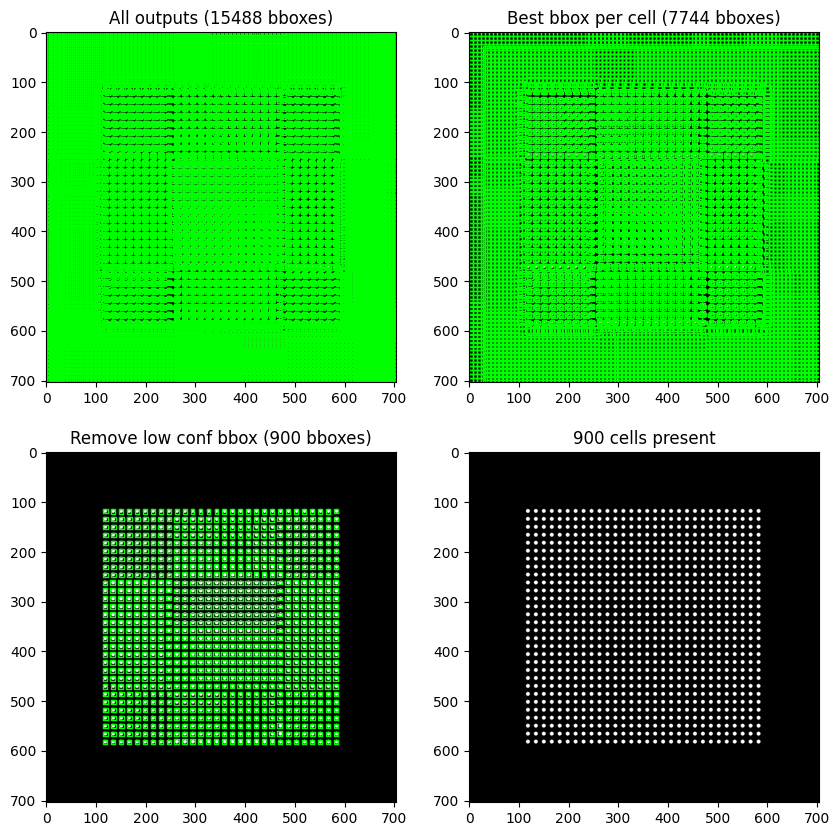

In [20]:
import importlib as imp
import yolo_help
imp.reload(yolo_help)
import yolo_post_help
imp.reload(yolo_post_help)

from matplotlib.patches import Rectangle

from yolo_help import get_best_bounding_box_per_cell, convert_data
from yolo_post_help import remove_low_conf_bboxes, NMS

img_real = plt.imread('/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg')
outdir = '/home/abenneck/Desktop/yolo_model/tiles_all_ch'
recon_data = np.load(os.path.join(outdir, f'recon.npz'))
recon_data = torch.Tensor(recon_data['data'])

B = net.B
stride = net.stride

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(padded_img)
axs[0,1].imshow(padded_img)
axs[1,0].imshow(padded_img)
axs[1,1].imshow(padded_img)
axs[1,1].set_title(f'{total_bbox} cells present')

# for tile in tiles:
#     p = tile['p']
#     r = random.random()
#     b = random.random()
#     g = random.random()
#     color = (r,b,g)
#     rec = Rectangle(p,tile_dim0,tile_dim1, facecolor=color, edgecolor='k',alpha = 0.5)
#     axs[1,0].add_patch(rec)
#     # rec = Rectangle(p,tile_dim0,tile_dim1, facecolor=color, edgecolor='k',alpha = 0.5)
#     # axs[0,1].add_patch(rec)

bboxes, data = convert_data(out[None], B, stride)
# bboxes, data = convert_data(recon_data[None], B, stride)

scores = torch.Tensor(data[:,-1])
predicted_rectangles = bbox_to_rectangles(np.asarray(bboxes),fc='none',ec='lime')#,alpha=scores)
axs[0,0].add_collection(predicted_rectangles)
axs[0,0].set_title(f'All outputs ({len(bboxes)} bboxes)')

start = time.time()
bboxes, scores = get_best_bounding_box_per_cell(bboxes, scores, B)
predicted_rectangles = bbox_to_rectangles(np.asarray(bboxes),fc='none',ec='lime')#,alpha=scores)
axs[0,1].add_collection(predicted_rectangles)
axs[0,1].set_title(f'Best bbox per cell ({len(bboxes)} bboxes)')
print(f'Finished Best bbox per cell in {time.time()-start:.2f}s')

start = time.time()
bboxes, scores = remove_low_conf_bboxes(bboxes, scores, conf_thresh = 0.1)
predicted_rectangles = bbox_to_rectangles(np.asarray(bboxes),fc='none',ec='lime')#,alpha=scores)
axs[1,0].add_collection(predicted_rectangles)
axs[1,0].set_title(f'Remove low conf bbox ({len(bboxes)} bboxes)')
print(f'Finished low conf in {time.time()-start:.2f}s')

# start = time.time()
# bboxes, scores = NMS(bboxes, scores)
# predicted_rectangles = bbox_to_rectangles(np.asarray(bboxes),fc='none',ec='lime',alpha=scores)
# axs[1,1].add_collection(predicted_rectangles)
# axs[1,1].set_title(f'NMS ({len(bboxes)} bboxes)')
# print(f'Finished NMS in {time.time()-start:.2f}s')

fig.set_size_inches(10,10)
# fig.set_size_inches(15,30)
fig.canvas.draw()

In [88]:
# scores = torch.Tensor(data[:,-1])
u_arr, c_arr = np.unique(scores, return_counts = True)

list(zip(u_arr,c_arr))
# list(zip(u_arr,c_arr))[::-1]

[(0.558656, 6),
 (0.5588957, 1),
 (0.5721948, 6),
 (0.5816836, 1),
 (0.6084687, 6),
 (0.6162213, 36),
 (0.61730677, 1),
 (0.61773175, 6),
 (0.61843956, 6),
 (0.61866903, 36),
 (0.6420661, 1),
 (0.6475238, 6),
 (0.64845794, 36),
 (0.6492984, 1),
 (0.6518343, 1),
 (0.6691861, 1),
 (0.66944253, 6),
 (0.67003495, 1),
 (0.67008924, 78),
 (0.6700985, 6),
 (0.67033166, 36),
 (0.67081356, 13),
 (0.6719553, 6),
 (0.67252773, 1),
 (0.6741732, 6),
 (0.680108, 13),
 (0.68360525, 6),
 (0.6910381, 6),
 (0.6992617, 1),
 (0.6999823, 6),
 (0.70142204, 1),
 (0.7016636, 6),
 (0.7130775, 78),
 (0.7132286, 13),
 (0.7146818, 169),
 (0.7158967, 1),
 (0.7173254, 6),
 (0.71962434, 1),
 (0.72584236, 13),
 (0.72662544, 13),
 (0.7268014, 78),
 (0.7367712, 1),
 (0.73776203, 1),
 (0.74351627, 1),
 (0.7443579, 6),
 (0.74490607, 78),
 (0.7449397, 1),
 (0.7450904, 6),
 (0.7458924, 13),
 (0.74809265, 1),
 (0.75009775, 1),
 (0.7516566, 1),
 (0.7528755, 6),
 (0.7537608, 6),
 (0.7549908, 13),
 (0.7551109, 13),
 (0.7681621

# Scratch Work

Finished extracting all tiles in 0.12s


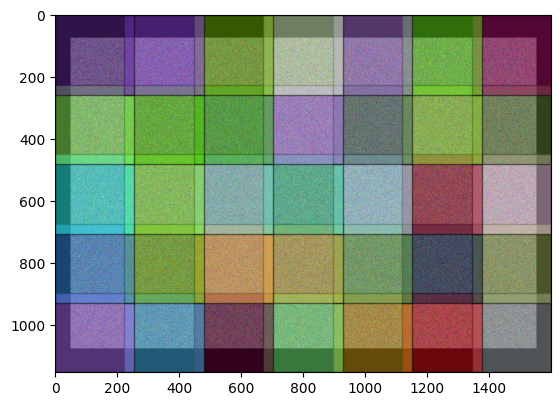

In [79]:
img_dim0 = 1000
img_dim1 = 1500
num_ch = 3

fig, ax = plt.subplots()
img = np.random.rand(img_dim0, img_dim1, num_ch)

# tile_n0 = int(img_dim0 / (tile_dim0-min_overlap)) # Number of tiles to extract along axis 0
# pad_dim0 = (tile_n0*(tile_dim0 - min_overlap) + tile_dim0)
# print(f'img_dim: {img_dim0}, padded: {pad_dim0}')

# tile_n1 = int(img_dim1 / (tile_dim1-min_overlap)) # Number of tiles to extract along axis 1
# pad_dim1 = (tile_n1*(tile_dim1 - min_overlap) + tile_dim1)
# print(f'img_dim: {img_dim1}, padded: {pad_dim1}')

# padded_img = np.zeros((pad_dim0, pad_dim1, num_ch))
# padded_img[:img_dim0,:img_dim1,:] = img

# img = padded_img.transpose((1,2,0))

padded_img, tiles = img_to_tiles(img, upper_threshold_bg = 210)

ax.imshow(padded_img)
for tile in tiles:
    p = tile['p']
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r,b,g)
    rec = Rectangle(p[::-1],tile_dim0,tile_dim1, facecolor=color, edgecolor='k',alpha = 0.5)
    ax.add_patch(rec)
    


### Testing the vectorization to be used in the best bbox step of postprocess()

In [ ]:
# Load a target image
start_total = time.time()
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
net = Net()
B = net.B
stride = net.stride

# Load input image
idx = 500
fname = sorted(os.listdir(img_dir))[idx]
img_path = os.path.join(img_dir, fname)
img = tifffile.imread(img_path)

# Preprocess using gamma correction + upsampling
start = time.time()
img_up = preprocess(img)
print(f'Finished preprocessing in {time.time()-start:.2f}s')

# Extract tiles from the preprocessed input image
padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04, verbose=True)

# Apply model to tiles + apply bbox edge filtering
print('Applying model to tiles . . .')
model_path = os.path.join('/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854')
model_path = os.path.join(model_path,'modelsave.pt')
out = apply_model_to_tiles(tiles, model_path, padded_img.shape[0], padded_img.shape[1], verbose=True)

# Convert the raw model output into a more useful data structure
pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2
print('Postprocessing . . .')
out_ = postprocess(out, B, stride, pads, up_factor=2, verbose=True)
# out = postprocess(out, B, stride, pads, verbose=True)

# Save/load the processed output
out_fname = (img_path.split('/')[-1]).split('.')[0] + '.npy'
out_path = f'/home/abenneck/Desktop/yolo_model/{out_fname}'
# np.save(out_path, out)
out = np.load(out_fname)


print(out_.shape)
print(out.shape)

print(out_[:,1000,1000])
print(out[:,1000,1000])

In [ ]:
import torch
idx = 500
fname = sorted(os.listdir(img_dir))[idx]
img_path = os.path.join(img_dir, fname)
out_fname = (img_path.split('/')[-1]).split('.')[0] + '.npy'
out_path = f'/home/abenneck/Desktop/yolo_model/{out_fname}'
out = np.load(out_fname)

best_bb = np.take_along_axis(out[:5*B], 5*np.argmax(out[4:5*B:5], axis=0)[None, ...] + np.arange(5)[:, None, None], axis=0)

out_ = np.concatenate([best_bb, out[5*B:]], axis=0)
out_.dtype

In [68]:
best_bb_idx = np.array(n_bb*np.argmax(out[(n_bb-1):n_bb*B:n_bb], axis=0)[None, ...] + np.arange(n_bb)[:, None, None], dtype=int)
out_ = np.concatenate([np.take_along_axis(out[:n_bb*B], best_bb_idx, axis=0), out[n_bb*B:]], axis=0)

out_[:,1000,1000]

array([  0.62482846,  -0.45395714,   0.28994614,   0.4283122 ,
       -10.04407   ,  -0.62499523,  -0.22214116,  -0.2993844 ],
      dtype=float32)

# The Tiles DataLoader

In [3]:
import os
from torch.utils.data import Dataset, DataLoader

class tileDataset(Dataset):
    def __init__(self, tiles):
        self.images = [tile['img'] for tile in tiles]
        self.all_p  = [tile['p'] for tile in tiles]
        self.all_bg = [tile['bg'] for tile in tiles]
        self.all_r  = [tile['r_idx'] for tile in tiles]
        self.n_row = np.max(self.all_r)
        self.all_c  = [tile['c_idx'] for tile in tiles]
        self.n_col = np.max(self.all_c)
        # self.transform = ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        prcb = {'p':self.all_p[idx], 'r':self.all_r[idx], 'c':self.all_c[idx], 'bg':self.all_bg[idx]}
        if len(img.shape) == 2: # If image is grayscale, add a color dimension
            img = img[None]
        return torch.tensor(img, dtype=torch.float32), prcb

def rem_bb(out, B, stride, tile_dim, boundary_cond = [16,16]):
    # Get the positions of the grid cells
    x = torch.arange(out.shape[-1])*stride + (stride-1)/2
    y = torch.arange(out.shape[-2])*stride + (stride-1)/2
    YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)
    
    # Convert bbox0 data to dimensions that are relative to the original input
    outB0 = out[:,:5]
    x0 = (torch.sigmoid(outB0[:,0])-0.5)*stride + YX[1] # between -0.5 and 0.5, scaled
    y0 = (torch.sigmoid(outB0[:,1])-0.5)*stride + YX[0]
    w0 = torch.exp(outB0[:,2])*stride
    h0 = torch.exp(outB0[:,3])*stride
    left0 = x0 - w0/2
    upper0 = y0 - h0/2
    
    # Convert bbox1 data to dimensions that are relative to the original input
    outB1 = out[:,5:10]    
    x1 = (torch.sigmoid(outB1[:,0])-0.5)*stride + YX[1] # between -0.5 and 0.5, scaled
    y1 = (torch.sigmoid(outB1[:,1])-0.5)*stride + YX[0]
    w1 = torch.exp(outB1[:,2])*stride
    h1 = torch.exp(outB1[:,3])*stride
    left1 = x1 - w1/2
    upper1 = y1 - h1/2
    
    # Compute upper and left bounds for all bboxes AND generate a mask of which bboxes meet the filtering criteria
    part_of_bb0 = torch.logical_or(left0 < boundary_cond[0], upper0 < boundary_cond[1])
    entire_bb0 = torch.logical_or(left0 >= (tile_dim-boundary_cond[0]), upper0 >= (tile_dim-boundary_cond[1]))
    remove_bb0 = torch.logical_or(part_of_bb0, entire_bb0).bool() # A mask of which bboxes should be removed to prevent double counting
    
    part_of_bb1 = torch.logical_or(left1 < boundary_cond[0], upper1 < boundary_cond[1])
    entire_bb1 = torch.logical_or(left1 >= (tile_dim-boundary_cond[0]), upper1 >= (tile_dim-boundary_cond[1]))
    remove_bb1 = torch.logical_or(part_of_bb1, entire_bb1).bool() # A mask of which bboxes should be removed to prevent double counting
    
    # Using the above masks, change conf of bboxes which are ar risk of being double counted to -inf
    out = out.clone()
    neg_inf0 = torch.full_like(out[:, 4], -torch.inf)
    neg_inf1 = torch.full_like(out[:, 9], -torch.inf)
    out[:, 4] = torch.where(remove_bb0, neg_inf0, out[:, 4]) # Update conf values for bbox0
    out[:, 9] = torch.where(remove_bb1, neg_inf1, out[:, 9]) # Update conf values for bbox1

    return out

In [4]:
img_idx = 500
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
fname = sorted(os.listdir(img_dir))[img_idx]
img_path = os.path.join(img_dir, fname)
img = tifffile.imread(img_path)
img_up = preprocess(img)
padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04)
pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2

nrow_t = int(np.max([tile['r_idx'] for tile in tiles])) + 1
ncol_t = int(np.max([tile['c_idx'] for tile in tiles])) + 1

ds = tileDataset(tiles)
dl = DataLoader(ds, batch_size = ncol_t, shuffle=False)

print(f'{nrow_t} x {ncol_t} tiles')

77 x 66 tiles


In [7]:
model_path = os.path.join('/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854')
model_path = os.path.join(model_path,'modelsave.pt')
dtype = torch.float32
net = Net()
net.load_state_dict(torch.load(model_path))
net.eval()

B = net.B
stride = net.stride

ds_factor = 8
tile_dim = 256
bbox_dim = 5
num_classes = 3
img_dim0 = padded_img.shape[0]
img_dim1 = padded_img.shape[1]
boundary_cond = (16,16)
ndim = 2

batch_start = time.time()
recon = np.zeros((bbox_dim*B+num_classes, int(img_dim0/ds_factor), int(img_dim1/ds_factor)))
print('Starting batch mode . . .')
for i_batch, batch in enumerate(dl):
    imgs, meta_data = batch
    if np.all(np.array(meta_data['bg'])):
        print(f'Skipping batch {i_batch}/{nrow_t}')
        continue
    else:
        start = time.time()
        out = net(imgs)
        for idx, elem in enumerate(out):
            out_i = remove_bbox_in_overlap(elem[None].clone().detach(), B, stride, tile_dim, boundary_cond = boundary_cond)
            # out_i = remove_bbox_in_overlap(elem[None].clone().detach(), B, stride, tile_dim, boundary_cond = boundary_cond)
            p0 = meta_data['p'][0][idx]
            p1 = meta_data['p'][1][idx]
            recon[:,int(p0/ds_factor):int((p0+tile_dim)/ds_factor), int(p1/ds_factor):int((p1+tile_dim)/ds_factor)] = out_i[0].detach().numpy()
        print(f'Finished batch {i_batch}/{nrow_t} in {time.time()-start:.2f}s')
        start = time.time()

recon = torch.tensor(recon, dtype=torch.float32)
recon = postprocess(recon, B, stride, pads, up_factor=2, verbose=True)

print(f'Finished ALL batches in {time.time()-batch_start:.2f}s\n')

last_idx = 0
tile_start = time.time()
start = time.time()
recon0 = np.zeros((bbox_dim*B+num_classes, int(img_dim0/ds_factor), int(img_dim1/ds_factor)))
recon1 = np.zeros((bbox_dim*B+num_classes, int(img_dim0/ds_factor), int(img_dim1/ds_factor)))
print('Starting tile mode . . .')
for idx, tile in enumerate(tiles):
    I = tile['img']
    if ndim == 2: # Model expects input shape of length 4, so 
        I = I[None]
    p = tile['p']
    bg = tile['bg']
    r_idx = tile['r_idx']
    c_idx = tile['c_idx']
    
    if bg:
        continue
        if verbose and idx % 100 == 0:
            print(f'Skipping tile {idx}/{len(tiles)} (r,c):({r_idx},{c_idx})')
    else:
        # Apply trained model to the image + define some key model outputs
        out = net((torch.tensor(I[None],dtype=dtype)))
        start0 = time.time()
        out_ = out.clone()
        out0 = rem_bb(out_, B, stride, tile_dim, boundary_cond = boundary_cond)
        recon0[:,int(p[0]/ds_factor):int((p[0]+tile_dim)/ds_factor), int(p[1]/ds_factor):int((p[1]+tile_dim)/ds_factor)] = out0[0].detach().numpy()
        if idx % 500 == 0:
            print(f'Finished rem_bb() in {time.time()-start0:.4f}s')

        start1 = time.time()
        out_ = out.clone()
        out1 = remove_bbox_in_overlap(out_, B, stride, tile_dim, boundary_cond = boundary_cond)
        recon1[:,int(p[0]/ds_factor):int((p[0]+tile_dim)/ds_factor), int(p[1]/ds_factor):int((p[1]+tile_dim)/ds_factor)] = out1[0].detach().numpy()
        if idx % 500 == 0:
            print(f'Finished remove_bbbox_in_overlap() in {time.time()-start1:.4f}s')

        if idx % 100 == 0:
            print(f'Finished tiles {last_idx}:{idx}/{len(tiles)} in {time.time()-start:.2f}s')
            start = time.time()
            last_idx = idx


recon0 = torch.tensor(recon0, dtype=torch.float32)
recon0_post = postprocess(recon0, B, stride, pads, up_factor=2, verbose=True)

recon1 = torch.tensor(recon1, dtype=torch.float32)
recon1_post = postprocess(recon1, B, stride, pads, up_factor=2, verbose=True)

print(f'Finished ALL tiles in {time.time()-tile_start:.2f}s')

Starting tile mode . . .
Finished tiles 0:1100/5082 in 22.46s
Finished tiles 1100:1300/5082 in 11.36s
Finished rem_bb() in 0.0010s
Finished remove_bbbox_in_overlap() in 0.0922s
Finished tiles 1300:1500/5082 in 11.46s
Finished tiles 1500:1600/5082 in 4.15s
Finished tiles 1600:1800/5082 in 12.91s
Finished rem_bb() in 0.0010s
Finished remove_bbbox_in_overlap() in 0.0935s
Finished tiles 1800:2000/5082 in 13.90s
Finished tiles 2000:2200/5082 in 14.32s
Finished tiles 2200:2400/5082 in 13.87s
Finished tiles 2400:2600/5082 in 12.96s
Finished tiles 2600:2800/5082 in 12.10s
Finished rem_bb() in 0.0010s
Finished remove_bbbox_in_overlap() in 0.0954s
Finished tiles 2800:3000/5082 in 10.94s
Finished tiles 3000:3200/5082 in 8.77s
Finished postprocessing in 0.26s
Finished postprocessing in 0.23s
Finished ALL tiles in 152.63s


Plotting bboxes . . .
Finished plotting bboxes0 in 67.17s, 3935136 boxes present
Finished plotting bboxes1 in 65.09s, 3935136 boxes present


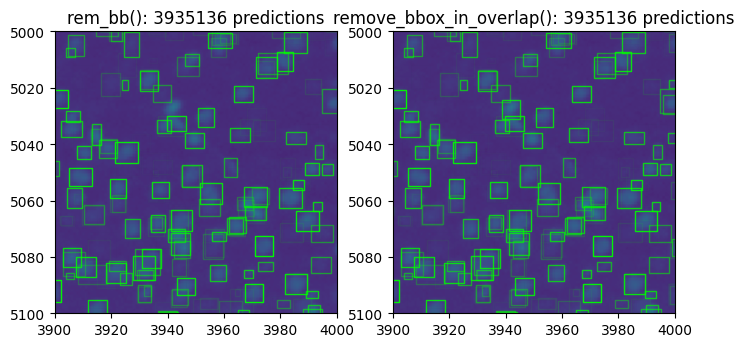

In [11]:
start = time.time()

# plotBbox = True

img_idx = 500
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
fname = sorted(os.listdir(img_dir))[img_idx]
img_path = os.path.join(img_dir, fname)

# if True:
#     img = tifffile.imread(img_path)
#     img_up = preprocess(img)
#     if plotBbox:
#         padded_img, tiles = img_to_tiles(img, lower_threshold_bg = 0.04, verbose=True)
#     else:
#         padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04, verbose=True)
#     tile_dim = tiles[0]['img'].shape[0]

img_plot = preprocess(img, upsample=False)

fig, ax = plt.subplots(1,2)

print('Plotting bboxes . . .')
ax[0].imshow(img_plot)
start = time.time()
scores = recon0_post[:,:,-4].ravel()
predicted_rectangles = bb_to_rec(recon0_post,fc='none',ec='lime',alpha=scores)
ax[0].add_collection(predicted_rectangles)
ax[0].set_title(f'rem_bb(): {len(scores)} predictions')
print(f'Finished plotting bboxes0 in {time.time()-start:.2f}s, {len(scores)} boxes present')

ax[1].imshow(img_plot)
# Filter out extra bboxes
start = time.time()
scores = recon1_post[:,:,-4].ravel()
predicted_rectangles = bb_to_rec(recon1_post,fc='none',ec='lime',alpha=scores)
ax[1].add_collection(predicted_rectangles)
ax[1].set_title(f'remove_bbox_in_overlap(): {len(scores)} predictions')
print(f'Finished plotting bboxes1 in {time.time()-start:.2f}s, {len(scores)} boxes present')

for ax_i in ax:
    ax_i.set_xlim([3900,4000])
    ax_i.set_ylim([5100,5000])

# ax[0].set_xlim([4000,4100])
# ax[0].set_ylim([6200,6100])
# ax[1].set_xlim([4000,4100])
# ax[1].set_ylim([6200,6100])

# print(f'Finished entire image in {time.time()-start:.2f}s')

fig.set_size_inches(8,4)
fig.canvas.draw()
# plt.savefig(f'/home/abenneck/Desktop/yolo_model/tiles_{img_idx}.png')

In [9]:
recon0.shape

torch.Size([13, 2160, 1852])

In [ ]:
u_arr, c_arr = np.unique(scores, return_counts=True)
for elem in list(zip(u_arr, c_arr))[::-1]:
    print(elem)

In [ ]:
start_total = time.time()

addTiles = True
plotBbox = False

img_idx = 500
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
fname = sorted(os.listdir(img_dir))[img_idx]
img_path = os.path.join(img_dir, fname)

if True:
    img = tifffile.imread(img_path)
    img_up = preprocess(img)
    if plotBbox:
        padded_img, tiles = img_to_tiles(img, lower_threshold_bg = 0.04, verbose=True)
    else:
        padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04, verbose=True)
    tile_dim = tiles[0]['img'].shape[0]

fig, ax = plt.subplots()

if plotBbox:
    ax.imshow(preprocess(img, upsample=False))
else:
    ax.imshow(padded_img)

out_fname = fname.split('.')[0] + '.npy'
out_path = f'/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v03_32bit/{out_fname}'
out_from_pipeline = torch.Tensor(np.load(out_path))
scores = out_from_pipeline[:,:,-4]

if addTiles:
    print('Adding tiles . . .')
    start = time.time()
    for tile in tiles:
        p = tile['p']
        bg = tile['bg']
        color = 'k' if bg else 'w'
        rec = Rectangle(p[::-1],tile_dim,tile_dim, facecolor=color, edgecolor='k',alpha = 0.2)
        ax.add_patch(rec)
    print(f'Finished plotting tiles in {time.time()-start:.2f}s, {len(scores)} boxes present')

if plotBbox:
    print('Plotting bboxes . . .')
    # Filter out extra bboxes
    start = time.time()
    # scores = out[:,:,4].ravel()
    scores = out[:,:,-4].ravel()
    predicted_rectangles = bb_to_rec(out_from_pipeline,fc='none',ec='lime',alpha=scores)
    ax.add_collection(predicted_rectangles)
    ax.set_title(f'{len(scores)} predictions')
    print(f'Finished plotting bboxes in {time.time()-start:.2f}s, {len(scores)} boxes present')

# ax.set_xlim([4000,4100])
# ax.set_ylim([6200,6100])

print(f'Finished entire image in {time.time()-start_total:.2f}s')

fig.canvas.draw()
# plt.savefig(f'/home/abenneck/Desktop/yolo_model/tiles_{img_idx}.png')

### Deprecated functions and workflows

In [8]:
# Check if 'bbox' meets our criteria using 'boundary_cond'
def isValid(bbox, boundary_cond, tile_dim, verbose=False):
    """
    Check to see if 'bbox' should be removed based on 2 filtering criterion: (1) If the entire bbox lies in the upper left exclusion zone or (2) If part of the bbox lies in the lower right exclsuion zone. The upper left exclusion zone is defined as the 'boundary_cond[0]' pixels on the upper boundary and the 'boundary_cond[1]' pixels on the left boundary of the image. The loewr right exclusion zone is defined as the 'boundary_cond[0]' pixels on the lower boundary and the 'boundary_cond[1]' pixels on the right boundary of the image.

    Parameters:
    -----------
    bbox : np.array(float)
        A bounding box defined as [cx, cy, w, h] centered at (cx,cy) with a width of w and a height of h
    boundary_cond : np.array(int)
        The thickness of the exclusion zones along each axis
    tile_dim : int
        The size of the tiles used in the YOLO pipeline
    verbose : bool
        Default False; If True, print out when a bbox is kept or remove. Useful for debugging.

    Returns:
    --------
    boolean_value : bool
        False if the bbox satisfies either boundayr condition and True otherwise.
    
    """
    # boundary_cond for exclusion zone
    cx, cy, w, h = bbox
    left_bound = cx - w/2
    upper_bound = cy - h/2

    # if left_bound < boundary_cond[0] or upper_bound < boundary_cond[1]:
    if left_bound < boundary_cond[0] or upper_bound < boundary_cond[1]:
        # Part of bbox lies in the Upper/Left EXCLUSION zone
        if verbose:
            print(f'PART - Removed bbox with bounds ({left_bound:.2f},{upper_bound:.2f})')
        return False
    elif (left_bound >= (tile_dim - boundary_cond[0])) or (upper_bound >= (tile_dim - boundary_cond[1])):
        # Entire bbox lies in the Lower/Right EXCLUSION zone
        if verbose:
            print(f'ENTIRE - Removed bbox with bounds ({left_bound:.2f},{upper_bound:.2f})')
        return False
    else:
        if verbose:
            print(f'Kept bbox with bounds ({left_bound:.2f},{upper_bound:.2f})')
        return True

# Remove invalid bboxes from 'out' by setting the corresponding conf value in 'out' to -inf
def remove_bbox_in_overlap(out, B, stride, tile_dim, boundary_cond = [16,16]):
    """
    Remove bounding boxes that lie in the exclusion zone defined by 'boundary_cond' from the model output before appending to reconstruction.

    Parameters:
    -----------
    out : torch.Tensor of shape [13, tile_dim/stride, tile_im/stride]
        The output from the YOLO model after processing a tile_dim x tile_dim image.
    B : int
        the number of target classes used in the YOLO model
    stride : int
        The nmuber of pixels the kernel moves during each step of the YOLO model
    tile_dim : int
        The dimensions of a tile extracted from the original image
    boundary_cond : np.array(int)
        The thickness of the exclusion zones along each axis

    Returns:
    --------
    out : torch.Tensor of shape [13, tile_dim/stride, tile_im/stride]
        The original output from the model, but now bboxes that don't meet the filtering criterion have a confidence of -inf.
    """

    # Get the positions of the grid cells
    x = torch.arange(out.shape[-1])*stride + (stride-1)/2
    y = torch.arange(out.shape[-2])*stride + (stride-1)/2
    YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)

    # Convert bbox0 data to dimensions that are relative to the original input
    outB0 = out[:,:5]
    x0 = (torch.sigmoid(outB0[:,0])-0.5)*stride + YX[1] # between -0.5 and 0.5, scaled
    y0 = (torch.sigmoid(outB0[:,1])-0.5)*stride + YX[0]
    w0 = torch.exp(outB0[:,2])*stride
    h0 = torch.exp(outB0[:,3])*stride
    x0 = x0 - w0/2
    y0 = y0 - h0/2

    # Convert bbox1 data to dimensions that are relative to the original input
    outB1 = out[:,5:10]    
    x1 = (torch.sigmoid(outB1[:,0])-0.5)*stride + YX[1] # between -0.5 and 0.5, scaled
    y1 = (torch.sigmoid(outB1[:,1])-0.5)*stride + YX[0]
    w1 = torch.exp(outB1[:,2])*stride
    h1 = torch.exp(outB1[:,3])*stride
    x1 = x1 - w1/2
    y1 = y1 - h1/2

    # Modify model output by setting conf of invalid bboxes to -inf
    numKeep = 0
    numRemove = 0
    for r in range(np.shape(out)[2]):
        for c in range(np.shape(out)[3]):
            line = out[0,:,r,c]

            # Extract bbox0 info for grid cell (r,c)
            x_ = x0[:,r,c].detach().numpy().item()
            y_ = y0[:,r,c].detach().numpy().item()
            w_ = w0[:,r,c].detach().numpy().item()
            h_ = h0[:,r,c].detach().numpy().item()
            bb0 = np.asarray([x_, y_, w_, h_])

            # print(f'(0,{r},{c}) - {bb0} : ', end='')
            if isValid(bb0, boundary_cond, tile_dim):
                numKeep += 1
            else:
                out[:,4,r,c] = -np.inf
                numRemove += 1

            # Extract bbox1 info for grid cell (r,c)
            x_ = x1[:,r,c].detach().numpy().item()
            y_ = y1[:,r,c].detach().numpy().item()
            w_ = w1[:,r,c].detach().numpy().item()
            h_ = h1[:,r,c].detach().numpy().item()
            bb1 = np.asarray([x_, y_, w_, h_])

            # print(f'(1,{r},{c}) - {bb1} : ', end='')
            if isValid(bb1, boundary_cond, tile_dim):
                numKeep += 1
            else:
                out[:,9,r,c] = -np.inf
                numRemove += 1

    return torch.Tensor(out)